<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2021/blob/main/01_Intro_to_NN_Pytorch/Week2_Intro_to_NN_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.buymeacoffee.com/sheikmohdimran" target="_blank"><img src="https://cdn.buymeacoffee.com/buttons/default-orange.png" alt="Buy Me A Coffee" height="30" width="120"></a>

You can support my work by buying me a coffee [here](https://www.buymeacoffee.com/sheikmohdimran).

In [1]:
!pip install fastai==2.4.1 -qqq
!pip install wandb -qqq
!pip install kaggle -qqq

     |████████████████████████████████| 188 kB 8.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 8.3 MB/s 
     |████████████████████████████████| 133 kB 62.2 MB/s 
     |████████████████████████████████| 170 kB 74.0 MB/s 
     |████████████████████████████████| 97 kB 7.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [ ]:
#@title Download Dataset
!echo '{"username":"imrandude","key":"<kaggle_key>"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip -q creditcardfraud.zip

## Introduction to Neural Networks - Fraud Detection

Nilson reports that U.S. card fraud (credit, debt, etc) was reportedly \$9 billion in 2016 and expected to increase to \$12 billion by 2020. For perspective, in 2017 both PayPal's and Mastercard's revenue was only $10.8 billion each.


**Objective:** In this notebook, given the credit card transactions, we will build a simple neural network (i.e., Multilayer perceptrons) for Fraud Detection using Pytorch and FastAI.

This notebooks covers,

1. Creating a Model

2. Adding Layers

3. Activations

4. Optimizers and Loss functions

5. Evaluation

### Dataset Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the original features and more background information about the data is not provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [6]:
dataset_file = './creditcard.csv'

In [7]:
data = pd.read_csv(dataset_file)

In [8]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data = data.drop("Time", axis = 1)

In [10]:
data = data.dropna()

In [11]:
X_data = data.iloc[:, :-1]

In [12]:
X_data.shape

(284807, 29)

In [13]:
X_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [14]:
y_data = data.iloc[:, -1]

In [15]:
y_data.shape

(284807,)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7,stratify = y_data)

In [17]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [18]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 29)
(56962, 29)
(227845,)
(56962,)


### 1. Creating a model

Model object can be created with Sequential class

### 2. Adding layers [layers and activations]

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added


In [24]:
import wandb
import torch
from torch import nn
from torch import sigmoid
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import sklearn.metrics as skm
from fastai.tabular.all import *
from fastai.callback.wandb import *
import wandb

In [21]:
!wandb login <wandb_api_key>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [97]:
train_loader=DataLoader(TensorDataset(torch.from_numpy(X_train.astype(np.float32)),
                                        torch.from_numpy(y_train.astype(np.float32))), 
                          batch_size=32)
test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32)),
                                        torch.from_numpy(y_test.astype(np.float32))), 
                          batch_size=640)

In [130]:
hidden = 64
input_dim = 29
model = nn.Sequential(
        nn.Linear(in_features=input_dim, out_features=hidden),
        nn.ReLU(),
        nn.BatchNorm1d(num_features=hidden),
        nn.Dropout(p=0.5),
        nn.Linear(hidden, 1),
        nn.Sigmoid()
    )

In [131]:
def _accumulate(self, learn):
    pred = to_detach(torch.round(learn.pred))
    targ = to_detach(learn.y)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def F1():
    return skm_to_fastai(skm.f1_score)

In [ ]:
wandb.init(name='Intro-to-NN-2', project='pytorch-basics',entity='sheikmohdimran')

### 3. Model compile [optimizers and loss functions]

Types of loss (function) and optimizer should be designated

Ref (optimizers): https://pytorch.org/docs/stable/optim.html

Ref (losses): https://pytorch.org/docs/stable/nn.html?highlight=loss#loss-functions


In [140]:
data = DataLoaders(train_loader, test_loader)

learn = Learner(data, 
                model, 
                loss_func=BCELossFlat(),                                                    #https://docs.fast.ai/losses.html#BCELossFlat
                opt_func=partial(OptimWrapper, opt=partial(torch.optim.SGD,momentum=0.9)),  #https://docs.fast.ai/migrating_pytorch_verbose.html#Optimizer
                metrics=F1(),                                                               #https://lschmiddey.github.io/fastpages_/2020/10/01/Tabular-Data-with-custom-metric.html
                cbs=[WandbCallback(),SaveModelCallback(monitor='f1_score')],                #https://docs.fast.ai/callback.wandb.html
                lr=0.1)

In [141]:
learn.fit(10)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,f1_score,time
0,0.008318,0.010138,0.706587,00:42
1,0.008029,0.013264,0.731429,00:42
2,0.005296,0.013216,0.735632,00:42
3,0.007494,0.013069,0.747126,00:42
4,0.007198,0.011461,0.739884,00:41
5,0.006431,0.019239,0.775281,00:42
6,0.006057,0.013108,0.747126,00:42
7,0.006179,0.011282,0.739884,00:42
8,0.006908,0.019254,0.770950,00:42
9,0.005606,0.013077,0.739884,00:42


Better model found at epoch 0 with f1_score value: 0.7065868263473053.
Better model found at epoch 1 with f1_score value: 0.7314285714285713.
Better model found at epoch 2 with f1_score value: 0.735632183908046.
Better model found at epoch 3 with f1_score value: 0.7471264367816092.
Better model found at epoch 5 with f1_score value: 0.7752808988764046.


### Sample output from Weights and Biases

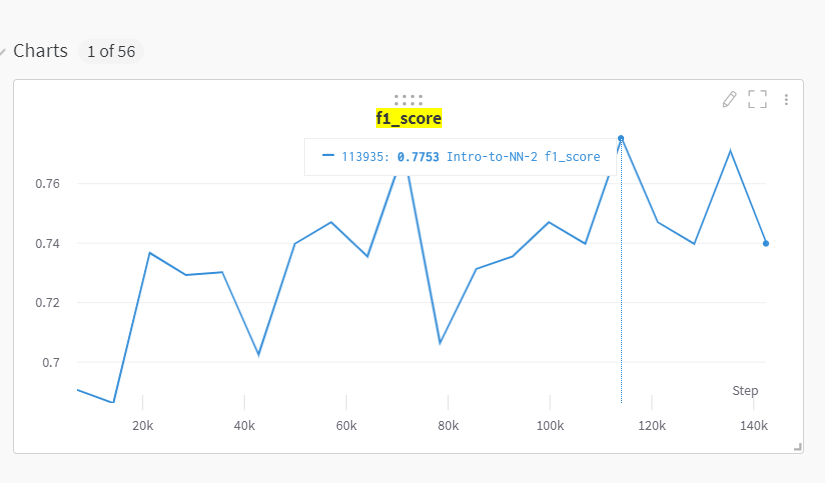

### 6. Evaluation
This step we will create a custom predict function to get the predictions. Based on the predictions we will display various metrics on the test set.

In [142]:
device = torch.device("cuda:0")

def predict(model, dataloader, n_class, device):
    model.eval()
    model.to(device)
    preds = np.zeros([0, n_class])
    for data, _ in dataloader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data).detach()
        y_pred = y_pred.cpu().numpy()
        preds = np.concatenate([preds, y_pred])
    return preds

In [143]:
test_preds = predict(model, test_loader, n_class=1, device=device)
preds=(test_preds>0.5).astype(float)
test_acc = skm.accuracy_score(y_test, preds)

### Confusion Matrix

In [144]:
print(f'test acc: {test_acc}')
print('recall_score:', recall_score(y_test,preds))
print('precision_score:', precision_score(y_test,preds))
print('f1_score:', f1_score(y_test,preds))
print(confusion_matrix(y_test, preds))

test acc: 0.9992977774656788
recall_score: 0.7040816326530612
precision_score: 0.8625
f1_score: 0.7752808988764046
[[56853    11]
 [   29    69]]


In [145]:
precision, recall, _ = precision_recall_curve(y_test, test_preds)

In [146]:
AUC_PRcurve= auc(recall, precision)

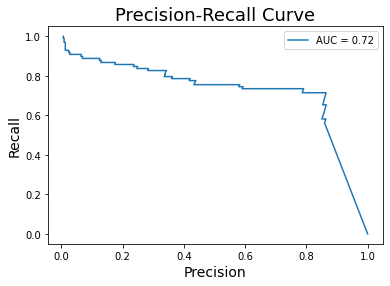

In [147]:
plt.figure(1)
#plot PR curve
plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve))
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()